In [1]:
import sys, os
sys.path.append('../palantiri/')

In [2]:
import numpy as np
import colorlover as cl
import plotly.graph_objs as go
from palantiri.RegretPlotHandler import RegretPlotHandler

In [3]:
class BanditAlgorithm(object):
    
    def __init__(self, k_arms):
        pass
    
    def select_arm(self):
        pass
    
    def update(self, chosen_arm, reward):
        pass

In [4]:
class UCB(BanditAlgorithm):
    
    def __init__(self,k_arms,beta=1):
        super().__init__(k_arms)
        
        self.emperical_mean = np.zeros(k_arms)
        self.count = np.zeros(k_arms)
        self.beta = beta
        
    def select_arm(self):
        
        if 0 in self.count:
            return self.count.tolist().index(0)
        
        ucb_values = self.emperical_mean + self.beta * np.sqrt(np.log(self.count.sum()) / self.count)

        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):

        self.count[chosen_arm] += 1

        n = self.count[chosen_arm]

        new_emperical_mean = ((n - 1) / n) * self.emperical_mean[chosen_arm] + (1 / n) * reward

        self.emperical_mean[chosen_arm] = new_emperical_mean


In [5]:
class ThompsonSampling(BanditAlgorithm):
    
    def __init__(self,k_arms,beta=1):
        
        super().__init__(k_arms)
        
        self.successes = np.zeros(k_arms)
        self.fails = np.zeros(k_arms)
        
    def select_arm(self):

        theta = np.random.beta(a=(self.successes + 1), b=(self.fails + 1))

        return np.argmax(theta)

    def update(self, chosen_arm, reward):

        self.successes[chosen_arm] += reward
        self.fails[chosen_arm] += (1-reward)

In [6]:
class BernoulliArm(object):

    def __init__(self, mu):
        self.mu = mu
  
    def draw(self):
        return np.random.binomial(n=1, p=self.mu)       

In [7]:
class BanditSimulation(object):
    
    def __init__(self, k_arms, T, number_of_runs):
        self.T = T
        self.number_of_runs = number_of_runs
        self.k_arms = k_arms
        self.cumulative_regret = {"Thompson Sampling":np.zeros((T,number_of_runs)),
                                  "UCB":np.zeros((T,number_of_runs))}
    
    def run(self):
        
        for run_number in range(self.number_of_runs):
            
            mu_vector = np.random.uniform(size=self.k_arms)
              
            arms = [BernoulliArm(mu) for mu in mu_vector]
            
            ucb = UCB(self.k_arms)
          
            thompson_sampling = ThompsonSampling(self.k_arms)
            
            for t in range(self.T):
                
                ucb_chosen_arm = ucb.select_arm()
                ucb_reward = arms[ucb_chosen_arm].draw()
                ucb.update(ucb_chosen_arm, ucb_reward)
                ucb_regret = max(mu_vector) - ucb_reward 
                
                thompson_sampling_chosen_arm = thompson_sampling.select_arm()
                thompson_sampling_reward = arms[thompson_sampling_chosen_arm].draw()
                thompson_sampling.update(thompson_sampling_chosen_arm, thompson_sampling_reward)
                thompson_sampling_regret = max(mu_vector) - thompson_sampling_reward

                if t==0:
                    self.cumulative_regret["UCB"][t,run_number] = ucb_regret
                    self.cumulative_regret["Thompson Sampling"][t,run_number] = thompson_sampling_regret
                else:
                    self.cumulative_regret["UCB"][t,run_number] = ucb_regret + self.cumulative_regret["UCB"][t-1,run_number]
                    self.cumulative_regret["Thompson Sampling"][t,run_number] = thompson_sampling_regret + self.cumulative_regret["Thompson Sampling"][t-1,run_number]

In [8]:
sim = BanditSimulation(6,500,500)

In [9]:
sim.run()

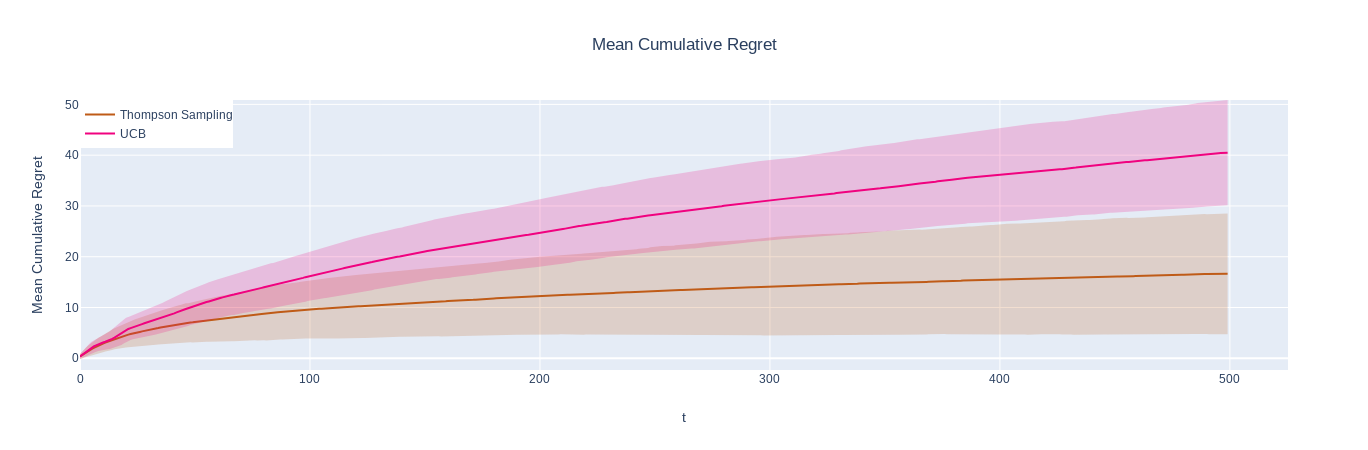

In [20]:
regret_plot_handler = RegretPlotHandler(sim.cumulative_regret)
regret_plot_handler.colors =cl.scales['7']['qual']['Accent']
regret_plot_handler.plot_regret(figure_layout=go.Layout(title=go.layout.Title(text='Mean Cumulative Regret',x=0.5),
                                                        xaxis=dict(title='t'),
                                                        yaxis=dict(title='Mean Cumulative Regret'),
                                                        legend=dict(
                                                            x=0,
                                                            y=1,
                                                            traceorder='normal')))